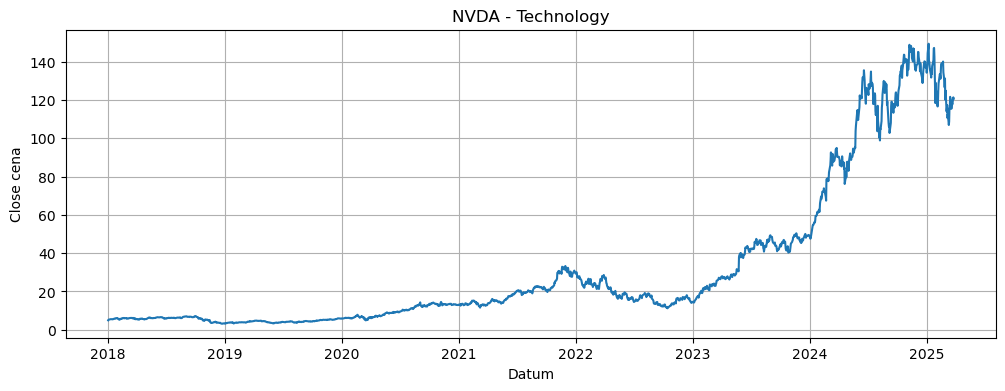

Připraveno 18 datasetů pro modely.


In [3]:
# Tento notebook načítá historická data akcií z CSV (včetně více parametrů), čistí je, normalizuje a připravuje vstupy pro LSTM modely s více vstupními featurami.

import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cesta ke složce se skripty
sys.path.append(os.path.abspath("../scripts"))
from utils import Normalizer, create_multifeature_lstm_dataset

# Parametry
WINDOW_SIZE = 20
TRAIN_SPLIT = 0.8

# Cesta k datům
base_path = "../data/downloaded_stock_data"

# Načítání dat
sektory = os.listdir(base_path)
data_by_sector = {}

for sektor in sektory:
    sektor_path = os.path.join(base_path, sektor)
    if not os.path.isdir(sektor_path):
        continue

    data_by_sector[sektor] = {}
    for file in os.listdir(sektor_path):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            path = os.path.join(sektor_path, file)
            try:
                df_raw = pd.read_csv(path, skiprows=2)
                df_raw.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]

                df_raw["Date"] = pd.to_datetime(df_raw["Date"], errors="coerce")
                for col in ["Open", "High", "Low", "Close", "Volume"]:
                    df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

                df = df_raw.dropna().sort_values("Date")
                data_by_sector[sektor][ticker] = df
            except Exception as e:
                print(f"Chyba u {file}: {e}")

# Ukázka jednoho záznamu
sektor_ukazka = list(data_by_sector.keys())[0]
ticker_ukazka = list(data_by_sector[sektor_ukazka].keys())[0]
df_ukazka = data_by_sector[sektor_ukazka][ticker_ukazka]
df_ukazka.tail()

# Vizualizace
plt.figure(figsize=(12, 4))
plt.plot(df_ukazka["Date"], df_ukazka["Close"])
plt.title(f"{ticker_ukazka} - {sektor_ukazka}")
plt.xlabel("Datum")
plt.ylabel("Close cena")
plt.grid(True)
plt.show()

# Normalizace a vytvoření datasetů
vsechny_datasety = []

for sektor, tickery in data_by_sector.items():
    for ticker, df in tickery.items():
        try:
            features = df[["Open", "High", "Low", "Volume"]].values
            target = df["Close"].values.reshape(-1, 1)

            feature_normalizer = Normalizer()
            target_normalizer = Normalizer()

            features_norm = feature_normalizer.fit_transform(features)
            target_norm = target_normalizer.fit_transform(target)

            x, y = create_multifeature_lstm_dataset(features_norm, target_norm, WINDOW_SIZE)
            split_idx = int(len(x) * TRAIN_SPLIT)

            vsechny_datasety.append({
                "sector": sektor,
                "ticker": ticker,
                "x_train": x[:split_idx],
                "y_train": y[:split_idx],
                "x_val": x[split_idx:],
                "y_val": y[split_idx:],
                "feature_normalizer": feature_normalizer,
                "target_normalizer": target_normalizer,
                "original_df": df
            })
        except Exception as e:
            print(f"Chyba při zpracování {ticker} ({sektor}): {e}")

print(f"Připraveno {len(vsechny_datasety)} datasetů pro modely.")

In [4]:
import pickle

with open("../data/preprocessed_datasets.pkl", "wb") as f:
    pickle.dump(vsechny_datasety, f)

print("Datasety úspěšně uloženy do preprocessed_datasets.pkl")

Datasety úspěšně uloženy do preprocessed_datasets.pkl
